<a href="https://colab.research.google.com/github/HagarIbrahiem/NLP_Topic_Modeling/blob/main/Topic_Modeling_for_Arabic_short_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [ ]:
# !pip install --upgrade ipykernel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
!pip install --upgrade pip
!pip install fastapi==0.68.0 kaleido==0.2.1 python-multipart==0.0.5 uvicorn==0.15.0 pandas==1.5.3
!pip install tmplot
!pip install python-bidi
!pip install arabic_reshaper
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install bitermplus
!pip install qalsadi
!pip install pyLDAvis
!pip install tomotopy

'''

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\n!pip install --upgrade pip\n!pip install fastapi==0.68.0 kaleido==0.2.1 python-multipart==0.0.5 uvicorn==0.15.0 pandas==1.5.3\n!pip install tmplot\n!pip install python-bidi\n!pip install arabic_reshaper\n!pip install git+https://github.com/rwalk/gsdmm.git\n!pip install bitermplus\n!pip install qalsadi\n!pip install pyLDAvis\n!pip install tomotopy\n\n'

In [ ]:
#Base and Cleaning
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from pprint import pprint
import pip
import setuptools
import tmplot as tmp
import spacy



# loading some necessary packages
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import ISRIStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from bidi.algorithm import get_display
import arabic_reshaper


from gensim.models.nmf import Nmf as GensimNmf
from gsdmm import MovieGroupProcess
from gensim.models import AuthorTopicModel
import tomotopy as tp
from gensim import models
from statistics import mean
import bitermplus as btm
from gensim.models import LdaSeqModel
import qalsadi.lemmatizer
from gensim.models import HdpModel


# Visualizations
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Global Variables
TXT_INDX = 1500

# Load Data

In [ ]:
data = pd.read_csv('tickets-commentcitizens.csv',index_col=0)
data.head()

,ID,citizenComment
0,7628.0,السلام عليكم\nلدي طلب رقم 746855 لم تتغير حالت...
1,7768.0,عدم الاستطاعة باضافة العقد الموثق
2,7771.0,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق
3,7796.0,هناك حساب فقد لا نتزكر كلمة السر الرقم القومى...
4,7830.0,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...


In [ ]:
data.rename(columns = {'citizenComment':'text'}, inplace = True)
data.drop(['ID'], axis=1)

,text
0,السلام عليكم\nلدي طلب رقم 746855 لم تتغير حالت...
1,عدم الاستطاعة باضافة العقد الموثق
2,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق
3,هناك حساب فقد لا نتزكر كلمة السر الرقم القومى...
4,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...
...,...
47736,السلام عليكم\nنظرا ا للظروف التي تحدث والانقطا...
47737,إلغاء الطلب رقم 3579676\nلدواعي السفر وعدم الج...
47738,بعد تركيب العداد تفاجأت بأنه إنتاج 2021 في حين...
47739,كم سعر الرسوم ؟؟؟؟؟؟


In [ ]:
len(data)

47741

# Data Pre-processing
Our goal in the data pre-processing stage is to convert sentences into words, convert words to
their root and removing words that are too common or too irrelevant to the purpose of our
topic modeling project,We used the following techniques to reach our goal:

- Remove Punctuations
- Remove StopWords
- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- Words are lemmatized and stemmed — words in the third person are changed to first person and verbs in past and future tenses are changed into the present and are reduced to their root form.

## Removing punctuation

In [ ]:
data['text'][TXT_INDX]

'بعد السلام عليكم \nتلقيت مكالمة من أحد موظفى الشركة الكرام للسؤال عن وجودى بمقر إقامتى لإجراء المقايسة اللازمة وتوجهت لمقر الشقة المطلوب تركيب العداد بها حيث أنى غير مقيم فى هذا المكان أغلب الوقت .\nفوجئت بالموظف المذكور عند معاودة اتصالة به بأن الشقة المطلوب تركيب عداد بها لا ينطبق عليها الشروط وأنه لابد من الإنتهاء من واجهة العقار وكذا التشطيبات مع تأكيدى له بأن وقف إجراء تلك التشطيبات قرار دولة وليس لى كمالك للوحدة داخل العقار محل الدراسة .\nلذا أرجو الإفادة وسرعة عمل المقايسة المطلوبة وتركيب العداد لأنه ليس من العدل أن أسدد ما يقرب من 500 جنيه شهرياً لمكان لا أقيم به .\nوتجدون سيادتكم مرفقاً مع هذا صورة من آخر سداد للممارسة .\nمع وافر الشكر والتقدير \nرضا شحات على خطاب'

In [ ]:

data['text'] = data['text'].map(lambda x: x.replace("#", " ").replace("_", " ").replace("|", " ").replace("؟", "").replace("!", " ")
                                          .replace('\"', " ").replace(';', "").replace(':', "").replace('(', "").replace(')', "")
                                          .replace('،', " ").replace('-', " ").replace('…', "").replace('\n', "").replace('.', ""))

In [ ]:
data['text'][TXT_INDX]

'بعد السلام عليكم تلقيت مكالمة من أحد موظفى الشركة الكرام للسؤال عن وجودى بمقر إقامتى لإجراء المقايسة اللازمة وتوجهت لمقر الشقة المطلوب تركيب العداد بها حيث أنى غير مقيم فى هذا المكان أغلب الوقت فوجئت بالموظف المذكور عند معاودة اتصالة به بأن الشقة المطلوب تركيب عداد بها لا ينطبق عليها الشروط وأنه لابد من الإنتهاء من واجهة العقار وكذا التشطيبات مع تأكيدى له بأن وقف إجراء تلك التشطيبات قرار دولة وليس لى كمالك للوحدة داخل العقار محل الدراسة لذا أرجو الإفادة وسرعة عمل المقايسة المطلوبة وتركيب العداد لأنه ليس من العدل أن أسدد ما يقرب من 500 جنيه شهرياً لمكان لا أقيم به وتجدون سيادتكم مرفقاً مع هذا صورة من آخر سداد للممارسة مع وافر الشكر والتقدير رضا شحات على خطاب'

## Remove StopWords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# let's check if nltk contains stopwords for arabic datasets
stopwords.fileids()

['arabic',
 'azerbaijani',
 'basque',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [ ]:
stopwords_list = stopwords.words('arabic')
print(stopwords_list)

['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل', 'على', 'عليك', 'عليه', 'عما', 'عن', 'عند', 'غير', 'فإذا', 'فإن', 'فلا', 'فمن', 'في', 'فيم', 'فيما', 'فيه', 'فيها', '

In [ ]:
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))
data['text'][TXT_INDX]

'السلام عليكم تلقيت مكالمة موظفى الشركة الكرام للسؤال وجودى بمقر إقامتى لإجراء المقايسة اللازمة وتوجهت لمقر الشقة المطلوب تركيب العداد مقيم فى المكان أغلب الوقت فوجئت بالموظف المذكور معاودة اتصالة بأن الشقة المطلوب تركيب عداد ينطبق عليها الشروط وأنه لابد الإنتهاء واجهة العقار وكذا التشطيبات تأكيدى بأن وقف إجراء التشطيبات قرار دولة وليس لى كمالك للوحدة داخل العقار محل الدراسة لذا أرجو الإفادة وسرعة عمل المقايسة المطلوبة وتركيب العداد لأنه العدل أسدد يقرب 500 شهرياً لمكان أقيم وتجدون سيادتكم مرفقاً صورة آخر سداد للممارسة وافر الشكر والتقدير رضا شحات خطاب'

## Drop Missing Values

In [ ]:
data.isnull().sum()

ID      0
text    0
dtype: int64

## lemmatization

- The library used for the lemmatization in our case is [Qalsadi](https://pypi.org/project/qalsadi/)

In [ ]:
def lemmatize_stemming(text):
    return qalsadi.lemmatizer.Lemmatizer().lemmatize(text)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stopwords_list and len(token) > 3:
            emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
            emoji_pattern.sub(r'', token)
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
# Copy data to documents
data_text = data[["text"]]
data_text["index"] = data_text.index
documents = data_text
documents

,text,index
0,السلام عليكملدي طلب رقم 746855 تتغير حالته 14 ...,0
1,عدم الاستطاعة باضافة العقد الموثق,1
2,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق,2
3,حساب فقد نتزكر كلمة السر الرقم القومى الخاص با...,3
4,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...,4
...,...,...
47736,السلام عليكمنظرا للظروف تحدث والانقطاع المستمر...,47736
47737,إلغاء الطلب رقم 3579676لدواعي السفر وعدم الجاه...,47737
47738,تركيب العداد تفاجأت بأنه إنتاج 2021 جارى ركب ع...,47738
47739,سعر الرسوم,47739


In [ ]:
# Checking The first row of the column text
data["text"][TXT_INDX]

'السلام عليكم تلقيت مكالمة موظفى الشركة الكرام للسؤال وجودى بمقر إقامتى لإجراء المقايسة اللازمة وتوجهت لمقر الشقة المطلوب تركيب العداد مقيم فى المكان أغلب الوقت فوجئت بالموظف المذكور معاودة اتصالة بأن الشقة المطلوب تركيب عداد ينطبق عليها الشروط وأنه لابد الإنتهاء واجهة العقار وكذا التشطيبات تأكيدى بأن وقف إجراء التشطيبات قرار دولة وليس لى كمالك للوحدة داخل العقار محل الدراسة لذا أرجو الإفادة وسرعة عمل المقايسة المطلوبة وتركيب العداد لأنه العدل أسدد يقرب 500 شهرياً لمكان أقيم وتجدون سيادتكم مرفقاً صورة آخر سداد للممارسة وافر الشكر والتقدير رضا شحات خطاب'

In [ ]:
#perform preprocess on first row
doc_sample = documents[documents['index'] == TXT_INDX].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


original document: 
['السلام', 'عليكم', 'تلقيت', 'مكالمة', 'موظفى', 'الشركة', 'الكرام', 'للسؤال', 'وجودى', 'بمقر', 'إقامتى', 'لإجراء', 'المقايسة', 'اللازمة', 'وتوجهت', 'لمقر', 'الشقة', 'المطلوب', 'تركيب', 'العداد', 'مقيم', 'فى', 'المكان', 'أغلب', 'الوقت', 'فوجئت', 'بالموظف', 'المذكور', 'معاودة', 'اتصالة', 'بأن', 'الشقة', 'المطلوب', 'تركيب', 'عداد', 'ينطبق', 'عليها', 'الشروط', 'وأنه', 'لابد', 'الإنتهاء', 'واجهة', 'العقار', 'وكذا', 'التشطيبات', 'تأكيدى', 'بأن', 'وقف', 'إجراء', 'التشطيبات', 'قرار', 'دولة', 'وليس', 'لى', 'كمالك', 'للوحدة', 'داخل', 'العقار', 'محل', 'الدراسة', 'لذا', 'أرجو', 'الإفادة', 'وسرعة', 'عمل', 'المقايسة', 'المطلوبة', 'وتركيب', 'العداد', 'لأنه', 'العدل', 'أسدد', 'يقرب', '500', 'شهرياً', 'لمكان', 'أقيم', 'وتجدون', 'سيادتكم', 'مرفقاً', 'صورة', 'آخر', 'سداد', 'للممارسة', 'وافر', 'الشكر', 'والتقدير', 'رضا', 'شحات', 'خطاب']


 tokenized and lemmatized document: 
['سلام', 'على', 'تلقى', 'مكالم', 'موظفى', 'شرك', 'كرام', 'سؤال', 'جودى', 'مقر', 'إقامتى', 'إجراء', 'مقايسة', 'لا

P.S. In this next part we will be using only 100 samples instead of the whole dataset to speed up the process

In [ ]:
documents = documents[:10]
documents

,text,index
0,السلام عليكملدي طلب رقم 746855 تتغير حالته 14 ...,0
1,عدم الاستطاعة باضافة العقد الموثق,1
2,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق,2
3,حساب فقد نتزكر كلمة السر الرقم القومى الخاص با...,3
4,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...,4
5,تاخرت المعاينة عنى علما بان غيرى اتته المعاينة...,5
6,عدم استطاعتي رفع عقد ايجار موثق,6
7,يرجي التكرم بالافاده الطلب المقدم بتاريخ 10 اغ...,7
8,لقد تقدمت بطلب تركيب عداد كودى وتمت كتابة الرق...,8
9,يتم تغير حالة الطلب اكثر شهرين الرجاء تغير حال...,9


In [ ]:
for txt in documents['text']:
  print(preprocess(txt))

['سلام', 'عليكملدي', 'تغير', 'حال', 'دراس', 'فن', 'رجاء', 'الافاده', 'حال', 'طلب', 'توقف', 'شكر']
['استطاعة', 'باضافة', 'عقد', 'موثق']
['استطاعة', 'تعديل', 'طلب', 'واضافة', 'عقد', 'موثق']
['حساب', 'نتزكر', 'كلم', 'سر', 'رقم', 'قومى', 'الخاص', 'حساب']
['سلام', 'على', 'الاول', 'عمل', 'اتاخر', 'كتير', 'عمل', 'تانى', 'رد', 'استكمال', 'بيان', 'وقف', 'عمل', 'تال', 'اتقبل', 'سرع', 'عاوز', 'حذف', 'خلى']
['تاخرت', 'معاين', 'علم', 'غيرى', 'اتته', 'معاين', 'عدى', 'مد', 'زمن']
['استطاعة', 'ايجار', 'موثق']
['رجى', 'تكرم', 'بالافاده', 'طلب', 'مقدم', 'تاريخ', 'اغسطس', 'رقم', 'طلب', 'للدراسه', 'الفنيه', 'الافاده', 'ال', 'تركيب']
['تقدم', 'طلب', 'تركيب', 'عداد', 'ودى', 'أمات', 'كتاب', 'رقم', 'قومى', 'تسبب', 'قبول', 'طلب', 'رجا', 'تصحيح', 'رقم', 'قومى', 'الخاص', 'تفعيل', 'طلب', 'الخاص', 'مرفق', 'صور', 'بطاقة', 'رقم', 'قومى']
['تغير', 'حال', 'طلب', 'كثر', 'شهر', 'رجاء', 'تغير', 'حال', 'طلب', 'انتهاء', 'المده']


In [ ]:
processed_docs = documents['text'].map(preprocess)
processed_docs

0    [سلام, عليكملدي, تغير, حال, دراس, فن, رجاء, ال...
1                         [استطاعة, باضافة, عقد, موثق]
2             [استطاعة, تعديل, طلب, واضافة, عقد, موثق]
3       [حساب, نتزكر, كلم, سر, رقم, قومى, الخاص, حساب]
4    [سلام, على, الاول, عمل, اتاخر, كتير, عمل, تانى...
5    [تاخرت, معاين, علم, غيرى, اتته, معاين, عدى, مد...
6                               [استطاعة, ايجار, موثق]
7    [رجى, تكرم, بالافاده, طلب, مقدم, تاريخ, اغسطس,...
8    [تقدم, طلب, تركيب, عداد, ودى, أمات, كتاب, رقم,...
9    [تغير, حال, طلب, كثر, شهر, رجاء, تغير, حال, طل...
Name: text, dtype: object

In [ ]:
type(processed_docs)

pandas.core.series.Series

## Tagging: POS & NER

In [ ]:
# create lists for just our tokens
# tokens_clean_list = sum(processed_docs.tolist(), []) #unpack our lists into a single list

# Explode the Series to convert lists into separate rows
x = processed_docs.explode()

# Convert the result back to a list
processed_docs = x.tolist()

print(processed_docs)

['سلام', 'عليكملدي', 'تغير', 'حال', 'دراس', 'فن', 'رجاء', 'الافاده', 'حال', 'طلب', 'توقف', 'شكر', 'استطاعة', 'باضافة', 'عقد', 'موثق', 'استطاعة', 'تعديل', 'طلب', 'واضافة', 'عقد', 'موثق', 'حساب', 'نتزكر', 'كلم', 'سر', 'رقم', 'قومى', 'الخاص', 'حساب', 'سلام', 'على', 'الاول', 'عمل', 'اتاخر', 'كتير', 'عمل', 'تانى', 'رد', 'استكمال', 'بيان', 'وقف', 'عمل', 'تال', 'اتقبل', 'سرع', 'عاوز', 'حذف', 'خلى', 'تاخرت', 'معاين', 'علم', 'غيرى', 'اتته', 'معاين', 'عدى', 'مد', 'زمن', 'استطاعة', 'ايجار', 'موثق', 'رجى', 'تكرم', 'بالافاده', 'طلب', 'مقدم', 'تاريخ', 'اغسطس', 'رقم', 'طلب', 'للدراسه', 'الفنيه', 'الافاده', 'ال', 'تركيب', 'تقدم', 'طلب', 'تركيب', 'عداد', 'ودى', 'أمات', 'كتاب', 'رقم', 'قومى', 'تسبب', 'قبول', 'طلب', 'رجا', 'تصحيح', 'رقم', 'قومى', 'الخاص', 'تفعيل', 'طلب', 'الخاص', 'مرفق', 'صور', 'بطاقة', 'رقم', 'قومى', 'تغير', 'حال', 'طلب', 'كثر', 'شهر', 'رجاء', 'تغير', 'حال', 'طلب', 'انتهاء', 'المده']


In [ ]:
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.blank("ar") # empty English pipeline

In [ ]:
# create a spacy doc from our raw text - better for pos tagging
spacy_doc = nlp(' '.join(processed_docs))

In [ ]:
# extract the tokens and pos tags into a dataframe
pos_df = pd.DataFrame(columns=['token', 'pos_tag'])

for token in spacy_doc:
    pos_df = pos_df._append({'token': token.text,
                            'pos_tag': token.pos_}, ignore_index=True)

In [ ]:
# token frequency count
pos_df_counts = pos_df.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_df_counts.head(10)

,token,pos_tag,counts
49,طلب,,9
41,رقم,,5
61,قومى,,4
32,حال,,4
4,استطاعة,,3
71,موثق,,3
27,تغير,,3
10,الخاص,,3
57,عمل,,3
45,سلام,,2


In [ ]:
# most common nouns
nouns = pos_df_counts[pos_df_counts.pos_tag == "NOUN"][0:10]
nouns

,token,pos_tag,counts


In [ ]:
# most common nouns
nouns = pos_df_counts[pos_df_counts.pos_tag == "VERB"][0:10]
nouns

,token,pos_tag,counts


NER

In [ ]:
# extract the tokens and entity tags into a dataframe
ner_df = pd.DataFrame(columns=['token', 'ner_tag'])

for token in spacy_doc.ents:
    if pd.isna(token.label_) is False:
        ner_df = ner_df.append({'token': token.text,
                                'ner_tag': token.label_}, ignore_index=True)

ner_df.head()

,token,ner_tag


In [ ]:
# token frequency count
ner_df_counts = ner_df.groupby(['token','ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
ner_df_counts.head(10)

,token,ner_tag,counts


In [ ]:
# most common people
people = ner_df_counts[ner_df_counts.ner_tag == "PERSON"][0:10]
people

,token,ner_tag,counts


##  Text Vectorization

### 1- Bag of words:

Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(dictionary)

Dictionary<694 unique tokens: ['الافاده', 'تغير', 'توقف', 'حال', 'دراس']...>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
count = 0
for k, v in dictionary.iteritems():
    print(v, k)
    count += 1
    if count > 10:
        break

الافاده 0
تغير 1
توقف 2
حال 3
دراس 4
رجاء 5
سلام 6
شكر 7
طلب 8
عليكملدي 9
فن 10


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

bow_corpus[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(11, 1), (12, 1), (13, 1), (14, 1)]

In [ ]:
type(bow_corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


list

In [ ]:
# SAmple of Topic 01
bow_doc_01 = bow_corpus[1]
for i in range(len(bow_doc_01)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_01[i][0],
                                                     dictionary[bow_doc_01[i][0]],
                                                     bow_doc_01[i][1]))

Word 11 ("استطاعة") appears 1 time.
Word 12 ("باضافة") appears 1 time.
Word 13 ("عقد") appears 1 time.
Word 14 ("موثق") appears 1 time.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Read More about  [BAG OF WORDS](https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm)

### 2- TF-IDF:



In [ ]:
tfidf = gensim.models.TfidfModel(bow_corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
corpus_tfidf = tfidf[bow_corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
type(corpus_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


gensim.interfaces.TransformedCorpus

In [ ]:
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3331245899059296),
 (1, 0.31003124674326116),
 (2, 0.36289708739353044),
 (3, 0.42228887586756975),
 (4, 0.2613901140107815),
 (5, 0.22843302763817536),
 (6, 0.17187068787877036),
 (7, 0.18965563811563327),
 (8, 0.08734328344935621),
 (9, 0.476593541696226),
 (10, 0.24920063309083484)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Modeling Part:


- In this section we are going to use the topic modeling algorithms and calculte the most important measure "coherence"

# 1- Latent Dirichlet Allocation( LDA)

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.037*"عداد" + 0.027*"طلب" + 0.024*"ممارس" + 0.016*"تعديل" + 0.014*"ارجو" + 0.012*"ملك" + 0.012*"ايصال" + 0.012*"تحويل" + 0.012*"عمل" + 0.011*"كهرباء"
Topic: 1 
Words: 0.036*"طلب" + 0.026*"حال" + 0.023*"عداد" + 0.017*"طلبة" + 0.016*"سلام" + 0.014*"شكر" + 0.014*"ارجو" + 0.014*"على" + 0.012*"عند" + 0.011*"سرع"
Topic: 2 
Words: 0.032*"منطق" + 0.019*"محمد" + 0.017*"رقم" + 0.017*"صور" + 0.017*"عداد" + 0.015*"تسجيل" + 0.015*"استكمال" + 0.015*"حضر" + 0.014*"طلب" + 0.013*"منزل"
Topic: 3 
Words: 0.025*"سداد" + 0.022*"ظهر" + 0.018*"طلب" + 0.017*"علم" + 0.014*"ايصال" + 0.013*"أوجد" + 0.011*"ممارس" + 0.010*"وحد" + 0.010*"عقد" + 0.010*"سكنة"
Topic: 4 
Words: 0.063*"طلب" + 0.019*"رقم" + 0.015*"عداد" + 0.015*"تقدم" + 0.015*"ممارس" + 0.014*"مستند" + 0.013*"قومى" + 0.012*"ال" + 0.012*"عمل" + 0.011*"قبول"
Topic: 5 
Words: 0.044*"طلب" + 0.026*"رقم" + 0.023*"تقديم" + 0.023*"قومى" + 0.013*"قدم" + 0.012*"شهر" + 0.012*"رجاء" + 0.012*"حال" + 0.012*"اسم" + 0.011*"تصحيح"
Topic: 6 
Words: 0.042*

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA Coherence with u_mass

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, dictionary=dictionary, coherence='u_mass',corpus=bow_corpus)
coherence_lda_uMass = coherence_model_lda.get_coherence()
print('\nCoherence Score with u_mass: ', coherence_lda_uMass)


Coherence Score with u_mass:  -6.98018273141368


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA cohernece with c_v

In [ ]:

# Compute Coherence Score with tfidf and u_mass parameter
coherence_model_lda = CoherenceModel(model=lda_model, dictionary=dictionary, coherence='c_v', texts =processed_docs  )
coherence_lda_cv = coherence_model_lda.get_coherence()
print('\nCoherence Score with c_v: ', coherence_lda_cv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score with c_v:  0.3773902117303259


### LDA Cohernece with c_npmi

In [ ]:
#corpus_tfidf
# Compute Coherence Score with tfidf and u_mass parameter
coherence_model_lda = CoherenceModel(model=lda_model, dictionary=dictionary, coherence='c_npmi', texts =processed_docs  )
coherence_lda_npmi = coherence_model_lda.get_coherence()
print('\nCoherence Score with c_npmi: ', coherence_lda_npmi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score with c_npmi:  -0.22991803843978667


### LDA Cohernece with C_uci

In [ ]:

coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_uci')
coherence_lda_uci = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_uci)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  -7.902149729069326


### Optimal number of topics LDA

The last step is to find the optimal number of topics.We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

read more about how to implement this step: https://datascience.oneoffcoder.com/topic-modeling-gensim.html

In [ ]:
results = []

for t in range(2,10):
    lda_model = gensim.models.LdaMulticore(bow_corpus, id2word=dictionary, passes=2, workers=2,num_topics=t)
    corpus_lda = lda_model[corpus_tfidf]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic,score
0,2,0.000000
1,3,0.000000
2,4,-0.472636
3,5,-0.378109
4,6,-1.575453
5,7,-1.121861
6,8,-1.654226
7,9,-3.328649


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


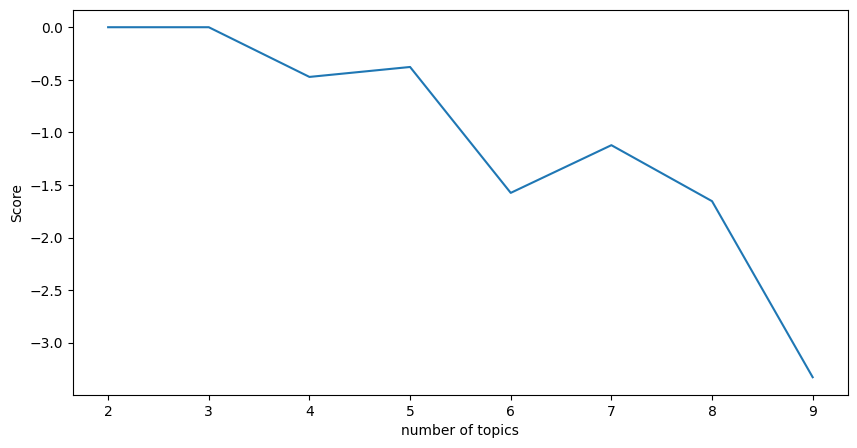

In [ ]:
plt.figure(figsize = (10,5))
s = pd.Series(results.score.values, index=results.topic.values)
plt.xlabel("number of topics")
plt.ylabel("Score")
_ = s.plot()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.039438  0.114996       1        1  34.828046
5      0.114868 -0.003037       2        1  11.270471
6      0.044678 -0.124888       3        1  11.102638
7     -0.041389 -0.008697       4        1  10.618920
8      0.087843  0.039071       5        1   9.273712
2     -0.079871  0.043071       6        1   7.229902
0     -0.106924  0.006872       7        1   7.097779
3      0.020077 -0.035714       8        1   5.154645
4     -0.078720 -0.031674       9        1   3.423888, topic_info=      Term       Freq      Total Category  logprob  loglift
21    قومى  14.000000  14.000000  Default  30.0000  30.0000
8      طلب  59.000000  59.000000  Default  29.0000  29.0000
18    حساب  11.000000  11.000000  Default  28.0000  28.0000
67    عداد  49.000000  49.000000  Default  27.0000  27.0000
22     كلم  13.000000  13.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
58    مقدم   0.541397   9.550445   Topic9  -4.8998   0.5042
180   مفيش   0.541385   4.222170   Topic9  -4.8998   1.3204
3      حال   0.541379  14.654113   Topic9  -4.8998   0.0760
296  عندما   0.541379   5.534095   Topic9  -4.8998   1.0498
255    ظهر   0.541376   5.445503   Topic9  -4.8998   1.0660

[540 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
183       4  0.694722  gmailcomرقم
184       4  0.695582         mtao
233       2  0.679904         أحيا
498       7  0.705645        أقساط
499       7  0.705647      أقساطمع
...     ...       ...          ...
693       6  0.757637        يقولى
583       4  0.692460           يم
232       1  0.386053          يوم
232       4  0.193026          يوم
232       8  0.193026          يوم

[756 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 8, 9, 3, 1, 4, 5])

# 2- LDA Sequence

In [ ]:

ldaseq = LdaSeqModel(corpus=bow_corpus, id2word=dictionary, time_slice=[438, 430, 456], num_topics=5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ldaseq.print_topics(time=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('منطق', 0.043321969214022794),
  ('عداد', 0.030724936642909494),
  ('كلم', 0.02410500956801214),
  ('تسجيل', 0.0209341255540323),
  ('نسى', 0.02064683592721252),
  ('ارجو', 0.017969857536017503),
  ('سلام', 0.017212808180199653),
  ('معاين', 0.0171197334506193),
  ('سر', 0.016772881419682386),
  ('على', 0.01492836503429033),
  ('عندما', 0.014927544858084287),
  ('كود', 0.014891420419377709),
  ('عمل', 0.014872313356853257),
  ('حضر', 0.014777556201957658),
  ('استكمال', 0.014285289750606093),
  ('خدم', 0.01403814128778541),
  ('الله', 0.013564221399835945),
  ('قدم', 0.013329605858671373),
  ('بركة', 0.013098253468138824),
  ('مركز', 0.013085220782116665)],
 [('طلب', 0.05420979137276309),
  ('رقم', 0.03693200019209953),
  ('قومى', 0.03005685150857413),
  ('حال', 0.020390792723451377),
  ('شكر', 0.02028835610342982),
  ('رجاء', 0.018340715777861564),
  ('صور', 0.017954241071219432),
  ('محمد', 0.015700487432784804),
  ('حساب', 0.01528635781997345),
  ('تحويل', 0.014971799764684244),


In [ ]:
ldaseq.print_topic_times(topic=0) # evolution of 1st topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('منطق', 0.043321969214022794),
  ('عداد', 0.030724936642909494),
  ('كلم', 0.02410500956801214),
  ('تسجيل', 0.0209341255540323),
  ('نسى', 0.02064683592721252),
  ('ارجو', 0.017969857536017503),
  ('سلام', 0.017212808180199653),
  ('معاين', 0.0171197334506193),
  ('سر', 0.016772881419682386),
  ('على', 0.01492836503429033),
  ('عندما', 0.014927544858084287),
  ('كود', 0.014891420419377709),
  ('عمل', 0.014872313356853257),
  ('حضر', 0.014777556201957658),
  ('استكمال', 0.014285289750606093),
  ('خدم', 0.01403814128778541),
  ('الله', 0.013564221399835945),
  ('قدم', 0.013329605858671373),
  ('بركة', 0.013098253468138824),
  ('مركز', 0.013085220782116665)],
 [('منطق', 0.04340718835728605),
  ('عداد', 0.030767108026560592),
  ('كلم', 0.02413350437402968),
  ('تسجيل', 0.020963432141044222),
  ('نسى', 0.020659434273296903),
  ('ارجو', 0.017980526141503042),
  ('سلام', 0.017239437900015833),
  ('معاين', 0.017141047304277617),
  ('سر', 0.0167892588171609),
  ('على', 0.014951686021955481)

### LDA seq cohererence with CV

In [ ]:


# we just have to specify the time-slice we want to find coherence for.

topics_dtm = ldaseq.dtm_coherence(time=0)

# running u_mass coherence on our models
dtm = CoherenceModel(topics=topics_dtm, corpus=bow_corpus,texts=processed_docs, dictionary=dictionary, coherence='c_v')
ldaseq_cv=dtm.get_coherence()


print ("Coherence score by cv: ", ldaseq_cv)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence score by cv:  0.46167152636335607


### LDA seq coherence with u_mass

In [ ]:


# we just have to specify the time-slice we want to find coherence for.

topics_dtm = ldaseq.dtm_coherence(time=0)

# running u_mass coherence on our models
dtm = CoherenceModel(topics=topics_dtm, corpus=bow_corpus,texts=processed_docs, dictionary=dictionary, coherence='u_mass')
ldaseq_umass=dtm.get_coherence()

print ("Coherence score by U_MASS: ",ldaseq_umass )


Coherence score by U_MASS:  -5.094354776937004


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA seq coherence with C_uci

In [ ]:

# we just have to specify the time-slice we want to find coherence for.

topics_dtm = ldaseq.dtm_coherence(time=0)

# running u_mass coherence on our models
dtm = CoherenceModel(topics=topics_dtm, corpus=bow_corpus,texts=processed_docs, dictionary=dictionary, coherence='c_uci')
ldaseq_cuci=dtm.get_coherence()

print ("Coherence score by c_uci: ", ldaseq_cuci)



Coherence score by c_uci:  -6.34059923942587


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA seq coherence with c_nmpi

In [ ]:


# we just have to specify the time-slice we want to find coherence for.

topics_dtm = ldaseq.dtm_coherence(time=0)

# running u_mass coherence on our models
dtm = CoherenceModel(topics=topics_dtm, corpus=bow_corpus,texts=processed_docs, dictionary=dictionary, coherence='c_npmi')
ldaseq_cnmpi=dtm.get_coherence()

print ("Coherence score by c_npmi: ",ldaseq_cnmpi)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence score by c_npmi:  -0.16398932416915407


# 3-  Biterm topic model (BTM)

In [ ]:
X, vocabulary, vocab_dict = btm.get_words_freqs(data['text'])
docs_vec = btm.get_vectorized_docs(data['text'], vocabulary)
biterms = btm.get_biterms(docs_vec)
model = btm.BTM(
    X, vocabulary, seed=12321, T=8, M=20, alpha=50/8, beta=0.01)
model.fit(biterms, iterations=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


In [ ]:
p_zd = model.transform(docs_vec)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 47741/47741 [00:01<00:00, 43198.14it/s]


In [ ]:

coherence = btm.coherence(model.matrix_topics_words_, X, M=2)

#coherence = model.coherence_

print(coherence)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-1.06590261 -1.18137941 -1.19074089 -1.18972784 -1.06590261 -1.08981458
 -1.39441695 -1.28041293]


In [ ]:
coherence.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(8,)

In [ ]:
coherence[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-1.1813794120868097

In [ ]:


coherence_mean = mean(coherence)

print(coherence_mean)

-1.1822872259471506


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

sum = 0
# loop from 1 to n
for num in range(1, (len(coherence)) + 1, 1):
    sum = sum + num
print("Sum of first ",(len(coherence)), "numbers is: ", sum)
average = sum /  (len(coherence))
print("Average of ", (len(coherence)), "numbers is: ", average)

Sum of first  8 numbers is:  36
Average of  8 numbers is:  4.5


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i in range(len(coherence)) :
    coh_mean = coherence[i]/ len(coherence)
    print(coh_mean)

-0.1332378257072891
-0.14767242651085122
-0.14884261107942617
-0.1487159801463197
-0.1332378257072891
-0.13622682224557256
-0.17430211842873272
-0.1600516161216701


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# Run the interactive report interface
tmp.report(model=model, docs=data['text'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/altair/utils/schemapi.py:462: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.
  resolver = jsonschema.RefResolver.from_schema(cls._rootschema or cls._schema)
/usr/local/lib/python3.10/dist-packages/altair/utils/schemapi.py:97: DeprecationWarning: jsons

In [ ]:
btm.get_docs_top_topic(data['text'], model.matrix_docs_topics_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,documents,label
0,السلام عليكملدي طلب رقم 746855 تتغير حالته 14 ...,6
1,عدم الاستطاعة باضافة العقد الموثق,4
2,عدم استطاعتي بتعديل الطلب واضافة العقد الموثق,7
3,حساب فقد نتزكر كلمة السر الرقم القومى الخاص با...,1
4,السلام عليكم الاول عملت طلب اتاخر كتير عملت طل...,5
...,...,...
47736,السلام عليكمنظرا للظروف تحدث والانقطاع المستمر...,2
47737,إلغاء الطلب رقم 3579676لدواعي السفر وعدم الجاه...,0
47738,تركيب العداد تفاجأت بأنه إنتاج 2021 جارى ركب ع...,2
47739,سعر الرسوم,3


# 4- Latent Semantic Indexing (LSI)

In [ ]:
data_words = list(processed_docs)
print(data_words[:1][0][:30])

['سلام', 'عليكملدي', 'تغير', 'حال', 'دراس', 'فن', 'رجاء', 'الافاده', 'حال', 'طلب', 'توقف', 'شكر']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=corpus_tfidf, id2word=dictionary, num_topics=10,chunksize=3000
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' 

In [ ]:
#lsi_model.show_topics()


for indx, topics in lsi_model.print_topics(num_topics=5, num_words=10):
    print('Topic: {} \nWords: {}'.format(indx, topics))

Topic: 0 
Words: 0.384*"منطق" + 0.207*"طلب" + 0.151*"رقم" + 0.148*"قومى" + 0.134*"تسجيل" + 0.126*"حضر" + 0.125*"ارجو" + 0.125*"تركيب" + 0.124*"تقديم" + 0.123*"عداد"
Topic: 1 
Words: -0.527*"منطق" + 0.211*"طلب" + -0.159*"يتسني" + -0.159*"اختار" + -0.159*"تغيير" + -0.159*"رحم" + -0.159*"سالت" + -0.150*"الاوراق" + 0.137*"قومى" + 0.137*"رقم"
Topic: 2 
Words: 0.465*"سر" + 0.424*"كلم" + 0.391*"نسى" + 0.158*"حساب" + 0.155*"قومى" + -0.150*"طلب" + 0.140*"رقم" + -0.120*"حال" + 0.113*"الخاص" + -0.110*"فن"
Topic: 3 
Words: -0.349*"قومى" + 0.243*"سر" + 0.239*"نسى" + -0.236*"رقم" + 0.207*"كلم" + 0.169*"حال" + -0.150*"صور" + -0.143*"تعديل" + 0.139*"دراس" + 0.136*"فن"
Topic: 4 
Words: 0.283*"شق" + -0.204*"دراس" + -0.198*"فن" + -0.193*"حال" + 0.185*"تركيب" + -0.174*"طلب" + 0.169*"ايصال" + -0.165*"رقم" + 0.164*"ودي" + -0.164*"قومى"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**print_topic**:
Return the result of show_topic, but formatted as a single string.

**- show_topic :**
Return a list of (word, probability)
2-tuples for the most probable words in topic topicid.

Only return 2-tuples for the topn most probable words (ignore the rest).

Read_more (https://tedboy.github.io/nlps/_modules/gensim/models/lsimodel.html#LsiModel.show_topics)

### LSI coherence with CV

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lsi_cv = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi_cv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4244832062110966


### LSI coherence with Umass

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='u_mass')
coherence_lsi_umass = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi_umass)


Coherence Score:  -8.614508234002525


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LSI coherence with C_nmpi

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='c_npmi')
coherence_lsi_nmpi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi_nmpi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  -0.2025631421124245


### LSI coherence with C_uci

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_docs, dictionary=dictionary, coherence='c_uci')
coherence_lsi_uci = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi_uci)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  -8.208682392925239


### Optimal number of topics LSI:

In [ ]:

results = []

for t in range(2,10):
    lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=t)
    corpus_lsi = lsi_model[corpus_tfidf]

    cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results_lsi = pd.DataFrame(results, columns=['topic', 'score'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' 

In [ ]:
results_lsi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic,score
0,2,0.000000
1,3,0.000000
2,4,-1.381551
3,5,-1.570605
4,6,-2.084445
5,7,-1.807443
6,8,-2.454071
7,9,-3.118589


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


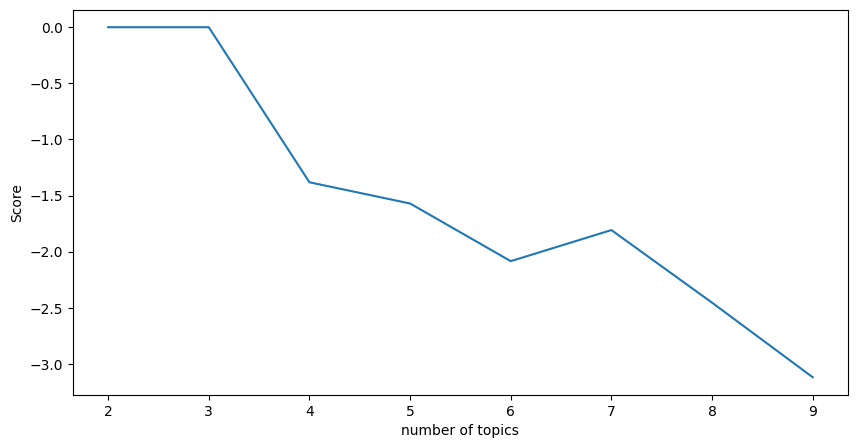

In [ ]:
plt.figure(figsize = (10,5))
s = pd.Series(results_lsi.score.values, index=results_lsi.topic.values)
plt.xlabel("number of topics")
plt.ylabel("Score")
_ = s.plot()

# 5- Hierarchical Dirichlet Process (HDP)

In [ ]:

hdp_model = HdpModel(bow_corpus,dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idxh, topich in hdp_model.print_topics(num_topics=5, num_words=10):
    print('Topic: {} \nWords: {}'.format(idxh, topich))

Topic: 0 
Words: 0.010*والقرءاه + 0.007*اقاف + 0.007*عليكمكيفية + 0.007*بركة + 0.007*وبركاتههل + 0.006*بالامس + 0.006*خطا + 0.006*اتذكر + 0.006*ماتروح + 0.006*تمك
Topic: 1 
Words: 0.013*أقول + 0.009*اتغيرت + 0.008*ارسال + 0.008*تقدير + 0.008*نجم + 0.008*مخزن + 0.007*احتمال + 0.007*متى + 0.007*ورد + 0.007*خدم
Topic: 2 
Words: 0.014*عايز + 0.009*حوالى + 0.008*فرق + 0.007*دافع + 0.007*عرف + 0.007*غير + 0.006*تاج + 0.006*موقع + 0.006*خلى + 0.006*أخذ
Topic: 3 
Words: 0.010*تكرم + 0.008*حسابى + 0.008*فقلتلهم + 0.007*محمود + 0.007*اتته + 0.007*ساعة + 0.006*قديم + 0.006*رسالة + 0.006*إيجار + 0.006*لماكينة
Topic: 4 
Words: 0.010*عشواء + 0.008*ارفاق + 0.007*سر + 0.007*شرط + 0.007*تيار + 0.007*فعل + 0.007*تفعيل + 0.007*عليكمكيفية + 0.007*لا + 0.007*علي


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### HDP coherence with  u_mass

In [ ]:

cm = CoherenceModel(model=hdp_model, corpus=bow_corpus, coherence='u_mass')
hdp_coherence_umass = cm.get_coherence()
print('\nCoherence Score u_mass: ', hdp_coherence_umass)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score u_mass:  -21.897519117009832


### HDP coherence with  cv

In [ ]:

cm = CoherenceModel(model=hdp_model, corpus=bow_corpus, coherence='c_v', texts = processed_docs)
hdp_coherence_cv = cm.get_coherence()
print('\nCoherence Score c_v: ', hdp_coherence_cv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score c_v:  0.7568760242121935


### HDP coherence with  c_uci

In [ ]:
from gensim.models import CoherenceModel
cm = CoherenceModel(model=hdp_model, corpus=bow_corpus, coherence='c_uci', texts = processed_docs)
hdp_coherence_uci = cm.get_coherence()
print('\nCoherence Score c_uci: ', hdp_coherence_uci)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score c_uci:  -16.82615914499982


### HDP coherence with  c_nmpi

In [ ]:

cm = CoherenceModel(model=hdp_model, corpus=bow_corpus, coherence='c_npmi', texts = processed_docs)
hdp_coherence_nmpi = cm.get_coherence()
print('\nCoherence Score c_npmi: ', hdp_coherence_nmpi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score c_npmi:  -0.5965619167668942


# 6- Non-Negative Matrix Factorization(NMF) :

In [ ]:

processed_docs = ' '.join(str(v) for v in processed_docs)
reshaped_text = arabic_reshaper.reshape(processed_docs)
bidi_text = get_display(reshaped_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# We only need the Headlines text column from the data
#the count vectorizer module needs string inputs, not array, so I join them with a space. This is a very quick operation.
train_headlines_sentences =[processed_docs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_headlines_sentences

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


["['سلام', 'عليكملدي', 'تغير', 'حال', 'دراس', 'فن', 'رجاء', 'الافاده', 'حال', 'طلب', 'توقف', 'شكر'] ['استطاعة', 'باضافة', 'عقد', 'موثق'] ['استطاعة', 'تعديل', 'طلب', 'واضافة', 'عقد', 'موثق'] ['حساب', 'نتزكر', 'كلم', 'سر', 'رقم', 'قومى', 'الخاص', 'حساب'] ['سلام', 'على', 'الاول', 'عمل', 'اتاخر', 'كتير', 'عمل', 'تانى', 'رد', 'استكمال', 'بيان', 'وقف', 'عمل', 'تال', 'اتقبل', 'سرع', 'عاوز', 'حذف', 'خلى'] ['تاخرت', 'معاين', 'علم', 'غيرى', 'اتته', 'معاين', 'عدى', 'مد', 'زمن'] ['استطاعة', 'ايجار', 'موثق'] ['رجى', 'تكرم', 'بالافاده', 'طلب', 'مقدم', 'تاريخ', 'اغسطس', 'رقم', 'طلب', 'للدراسه', 'الفنيه', 'الافاده', 'ال', 'تركيب'] ['تقدم', 'طلب', 'تركيب', 'عداد', 'ودى', 'أمات', 'كتاب', 'رقم', 'قومى', 'تسبب', 'قبول', 'طلب', 'رجا', 'تصحيح', 'رقم', 'قومى', 'الخاص', 'تفعيل', 'طلب', 'الخاص', 'مرفق', 'صور', 'بطاقة', 'رقم', 'قومى'] ['تغير', 'حال', 'طلب', 'كثر', 'شهر', 'رجاء', 'تغير', 'حال', 'طلب', 'انتهاء', 'المده'] ['تقدم', 'طلب', 'عداد', 'ودي', 'طلب', 'حتى', 'ال', 'عرف', 'موقف', 'طلب', 'متى', 'أتم', 'تركيب

In [ ]:
vectorizer = CountVectorizer();
x_counts = vectorizer.fit_transform(train_headlines_sentences);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#obtain a NMF model.
modelNMF = NMF(n_components=10, init=None);
#fit the model
modelNMF.fit(xtfidf_norm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NMF(n_components=10)

In [ ]:
def get_nmf_topics(modelNMF, n_top_words):

    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names_out()

    word_dict = {};
    for i in range(10):

        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = modelNMF.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;

    return pd.DataFrame(word_dict);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
get_nmf_topics(modelNMF, 20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,طلب,كود,استطاع,قدمتهفما,عندما,للدراسه,الكودى,قابل,قومى,صفح
1,عداد,استفسار,مركز,شهر,الله,مراجع,استخراج,محول,نرجوا,اعادة
2,ممارس,قال,ناس,حدث,ودي,مفيش,تأجير,شق,مخزن,أتم
3,رقم,دراس,لاس,تحديد,تعليق,حال,خدمة,مدون,وجود,ورى
4,تركيب,كلم,رساله,استطاعة,رساله,المشكله,مخافون,مقدم,صدر,الطيبالطيب
5,تقديم,عداد,مال,على,على,كدهلماذا,ارسلته,أولوي,اختيار,تقسيط
6,اسم,حساب,تسجيل,سارق,كثر,كهرباء,gmailcomرقم,تعاون,الدراسه,المواطنينحيث
7,محمد,استكمال,قبول,ملف,الخاص,أقساط,جبى,انها,أخذ,السيستم
8,سلام,سابق,مساعد,استفيد,مفعل,لان,كتاب,تحديث,كد,كتير
9,ارجو,نسى,زملاء,دائم,عمود,الشهريه,بيقولوا,إرسال,قالولى,صلح


In [ ]:

nmf = GensimNmf(
    corpus=bow_corpus,
    num_topics=5,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/usr/local/lib/python3.10/dist-packages/gensim/models/nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/usr/local/lib/python3.10/dist-packages/gensim/models/nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `s

### NMF coherence with Umass

In [ ]:
cm = CoherenceModel(model=nmf,dictionary=id2word, corpus=bow_corpus, coherence='u_mass')
nmf_coherence_uMass = cm.get_coherence()
print('\nCoherence Score u_mass: ', nmf_coherence_uMass)


Coherence Score u_mass:  -4.323521325705409


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### NMF coherence with C_nmpi

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

cm = CoherenceModel(model=nmf,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_npmi')
nmf_coherence_cnmpi = cm.get_coherence()
print('\nCoherence Score c_npmi: ', nmf_coherence_cnmpi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score c_npmi:  -0.24881150682721237


### NMF coherence with c_uci

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
cm = CoherenceModel(model=nmf,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_uci')
nmf_coherence_cuci = cm.get_coherence()
print('\nCoherence Score c_uci: ', nmf_coherence_cuci)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score c_uci:  -7.035551143769361


### NMF coherence with cv

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
cm = CoherenceModel(model=nmf,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_v')
nmf_coherence_cv = cm.get_coherence()
print('\nCoherence Score c_cv: ', nmf_coherence_cv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score c_cv:  0.4408594769871198


# 7- Pachinko allocation (PAM)

In [ ]:

k = 5
mdl = tp.PAModel(k1=5, k2=25)
for line in [processed_docs]:
    mdl.add_doc(line.strip().split())

for i in range(10,100,10):
    mdl.train(100)
    print('Iteration: {}\tLog-likelihood: {}'.format( i,mdl.ll_per_word))

# save into file
#mdl.save('sample_PAM_model.bin')

# load from file
#mdl = tp.PAModel.load('sample_PAM_model.bin')
for s in range(mdl.k):
    if not mdl.get_sub_topics(s): continue
    print('Top 10 words of topic #{}'.format(s))
    print(mdl.get_topic_words(k,top_n=10))


Iteration: 10	Log-likelihood: -8.33607533250225


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration: 20	Log-likelihood: -8.242699589968531
Iteration: 30	Log-likelihood: -8.077643691060263
Iteration: 40	Log-likelihood: -8.052044453575999
Iteration: 50	Log-likelihood: -8.117949128698854
Iteration: 60	Log-likelihood: -8.108279428083549
Iteration: 70	Log-likelihood: -8.052737285180813
Iteration: 80	Log-likelihood: -8.046791249898439
Iteration: 90	Log-likelihood: -8.066799302274617
Top 10 words of topic #0
[("'رجاء',", 0.11833038181066513), ("'صفح',", 0.05926363170146942), ("'مستند',", 0.05926363170146942), ("'ميل',", 0.039574719965457916), ("'باه',", 0.039574719965457916), ("'ظهر',", 0.039574719965457916), ("'كامل',", 0.039574719965457916), ("'شرط',", 0.039574719965457916), ("'ألزم',", 0.019885804504156113), ("'احتمال',", 0.019885804504156113)]
Top 10 words of topic #1
[("'رجاء',", 0.11833038181066513), ("'صفح',", 0.05926363170146942), ("'مستند',", 0.05926363170146942), ("'ميل',", 0.039574719965457916), ("'باه',", 0.039574719965457916), ("'ظهر',", 0.039574719965457916), ("'كامل

### PAM coherence with Umass

In [ ]:

coh = tp.coherence.Coherence(mdl, coherence='u_mass')
PAM_umass_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('u_mass'))
print('Average:', PAM_umass_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : u_mass ====
Average: -1.1102230246251565e-16 
Per Topic: [-1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### PAM coherence C_uci

In [ ]:

coh = tp.coherence.Coherence(mdl, coherence='c_uci')
PAM_cuci_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('c_uci'))
print('Average:', PAM_cuci_coherence, '\nPer Topic:', coherence_per_topic)
print()


==== Coherence : c_uci ====
Average: -16.102059225023602 
Per Topic: [-16.343987733776213, -18.16420186405492, -14.158720727869738, -16.29023030203939, -15.553155497377743]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### PAM coherence with c_nmpi

In [ ]:

coh = tp.coherence.Coherence(mdl, coherence='c_npmi')
PAM_cnpmi_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('c_npmi'))
print('Average:', PAM_cnpmi_coherence, '\nPer Topic:', coherence_per_topic)
print()


==== Coherence : c_npmi ====
Average: -0.5637248283107004 
Per Topic: [-0.5703220576802837, -0.6437858201806881, -0.49720931410550673, -0.5678178795324123, -0.5394890700546118]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### PAM coherence with cv

In [ ]:

coh = tp.coherence.Coherence(mdl, coherence='c_v')
PAM_cv_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
print('==== Coherence : {} ===='.format('c_v'))
print('Average:', PAM_cv_coherence, '\nPer Topic:', coherence_per_topic)
print()


==== Coherence : c_v ====
Average: 0.4359591899067164 
Per Topic: [0.36282448917627336, 0.4571799121797085, 0.4193894758820534, 0.4129203543066978, 0.5274817179888487]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 8- Hierarchical Pachinko allocation (HPAM)

In [ ]:

k = 5
mdlH = tp.HPAModel(k1=5, k2=25)

for line in [processed_docs]:
    mdlH.add_doc(line.strip().split())

for i in range(10,100,10):
    mdlH.train(100)
    print('Iteration: {}\tLog-likelihood: {}'.format( i,mdlH.ll_per_word))

# save into file
#mdl.save('sample_PAM_model.bin')

# load from file
#mdl = tp.PAModel.load('sample_PAM_model.bin')
for s in range(mdlH.k):
    if not mdlH.get_sub_topics(s): continue
    print('Top 10 words of topic #{}'.format(s))
    print(mdlH.get_topic_words(k,top_n=10))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration: 10	Log-likelihood: -8.163597108588743
Iteration: 20	Log-likelihood: -7.864442347974424
Iteration: 30	Log-likelihood: -7.7614954479902485
Iteration: 40	Log-likelihood: -7.4495152905357465
Iteration: 50	Log-likelihood: -6.907312110484259
Iteration: 60	Log-likelihood: -7.031815354083457
Iteration: 70	Log-likelihood: -6.277075506475444
Iteration: 80	Log-likelihood: -5.437177466372931
Iteration: 90	Log-likelihood: -4.7222454602930135
Top 10 words of topic #0
[("'لكم',", 0.0803583413362503), ("'نسى',", 0.06698756664991379), ("'عطية',", 0.05361679568886757), ("'اختار',", 0.05361679568886757), ("'صحيح',", 0.05361679568886757), ("['تسجيل',", 0.04024602100253105), ("'ومحدش',", 0.04024602100253105), ("['استطاعة',", 0.04024602100253105), ("'لاس',", 0.04024602100253105), ("'مبلغ',", 0.026875250041484833)]
Top 10 words of topic #1
[("'لكم',", 0.0803583413362503), ("'نسى',", 0.06698756664991379), ("'عطية',", 0.05361679568886757), ("'اختار',", 0.05361679568886757), ("'صحيح',", 0.05361679568

### HPAM coherence with Umass

In [ ]:

coh = tp.coherence.Coherence(mdlH, coherence='u_mass')
HPAM_umass_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlH.k)]
print('==== Coherence : {} ===='.format('u_mass'))
print('Average:', HPAM_umass_coherence, '\nPer Topic:', coherence_per_topic)
print()


==== Coherence : u_mass ====
Average: -1.1102230246251565e-16 
Per Topic: [-1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### HPAM coherence with C_uci

In [ ]:

coh = tp.coherence.Coherence(mdlH, coherence='c_uci')
HPAM_cuci_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlH.k)]
print('==== Coherence : {} ===='.format('c_uci'))
print('Average:', HPAM_cuci_coherence, '\nPer Topic:', coherence_per_topic)
print()


==== Coherence : c_uci ====
Average: -13.006103217914367 
Per Topic: [-11.831270061998712, -14.17619077217918, -7.998226019522782, -15.864370110303096, -15.160459125568071]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### HPAM coherence with C_nmpi

In [ ]:

coh = tp.coherence.Coherence(mdlH, coherence='c_npmi')
HPAM_cnmpi_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlH.k)]
print('==== Coherence : {} ===='.format('c_npmi'))
print('Average:', HPAM_cnmpi_coherence, '\nPer Topic:', coherence_per_topic)
print()


==== Coherence : c_npmi ====
Average: -0.45083500952361594 
Per Topic: [-0.4200469399197788, -0.47794759316996976, -0.2907946459911006, -0.5515267702661427, -0.5138590982710877]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### HPAM coherence with CV

In [ ]:

coh = tp.coherence.Coherence(mdlH, coherence='c_v')
HPAM_cv_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlH.k)]
print('==== Coherence : {} ===='.format('c_v'))
print('Average:', HPAM_cv_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.46099157951772207 
Per Topic: [0.39290006905794145, 0.5506708804517985, 0.3279596112668514, 0.5272412195801734, 0.5061861172318458]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 9- Dirichlet Multinomial Regression(DMR)

In [ ]:

corpus = tp.utils.Corpus()

mdlD = tp.DMRModel(tw=tp.TermWeight.ONE,
    k=20,
    corpus=corpus)

for line in [processed_docs]:
    mdlD.add_doc(line.strip().split())

for i in range(10,100,10):
    mdlD.train(100)
    print('Iteration: {}\tLog-likelihood: {}'.format( i,mdlD.ll_per_word))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration: 10	Log-likelihood: -8.053978401818368
Iteration: 20	Log-likelihood: -7.979474772611879
Iteration: 30	Log-likelihood: -8.026852293504167
Iteration: 40	Log-likelihood: -7.99790364798655
Iteration: 50	Log-likelihood: -8.052444711138042
Iteration: 60	Log-likelihood: -8.010336487572877
Iteration: 70	Log-likelihood: -8.008722323490884
Iteration: 80	Log-likelihood: -8.055606604296253
Iteration: 90	Log-likelihood: -7.981812052720008


In [ ]:
for i in range(0, 2000, 20):
    print('Iteration: {:04} LL per word: {:.4}'.format(i, mdlD.ll_per_word))
    mdlD.train(20)
print('Iteration: {:04} LL per word: {:.4}'.format(2000, mdlD.ll_per_word))

mdlD.summary()

Iteration: 0000 LL per word: -7.982
Iteration: 0020 LL per word: -7.996
Iteration: 0040 LL per word: -7.994
Iteration: 0060 LL per word: -7.97
Iteration: 0080 LL per word: -8.015
Iteration: 0100 LL per word: -8.015
Iteration: 0120 LL per word: -8.031
Iteration: 0140 LL per word: -8.002
Iteration: 0160 LL per word: -8.036
Iteration: 0180 LL per word: -7.987
Iteration: 0200 LL per word: -8.057
Iteration: 0220 LL per word: -8.028


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration: 0240 LL per word: -8.02
Iteration: 0260 LL per word: -8.052
Iteration: 0280 LL per word: -8.098
Iteration: 0300 LL per word: -8.001
Iteration: 0320 LL per word: -8.002
Iteration: 0340 LL per word: -8.051
Iteration: 0360 LL per word: -8.083
Iteration: 0380 LL per word: -8.032
Iteration: 0400 LL per word: -7.986
Iteration: 0420 LL per word: -7.985
Iteration: 0440 LL per word: -8.041
Iteration: 0460 LL per word: -7.963
Iteration: 0480 LL per word: -8.057
Iteration: 0500 LL per word: -8.016
Iteration: 0520 LL per word: -8.034
Iteration: 0540 LL per word: -7.974
Iteration: 0560 LL per word: -8.099
Iteration: 0580 LL per word: -8.012
Iteration: 0600 LL per word: -8.026
Iteration: 0620 LL per word: -8.008
Iteration: 0640 LL per word: -8.011
Iteration: 0660 LL per word: -8.01
Iteration: 0680 LL per word: -7.949
Iteration: 0700 LL per word: -7.987
Iteration: 0720 LL per word: -8.039
Iteration: 0740 LL per word: -8.037
Iteration: 0760 LL per word: -8.009
Iteration: 0780 LL per word: -

### DMR coherence with U_mass

In [ ]:
coh = tp.coherence.Coherence(mdlD, coherence='u_mass')
DMR_umass_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlD.k)]
print('==== Coherence : {} ===='.format('u_mass'))
print('Average:', DMR_umass_coherence, '\nPer Topic:', coherence_per_topic)
print()


==== Coherence : u_mass ====
Average: -1.1102230246251565e-16 
Per Topic: [-1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### DMR coherence with C_V

In [ ]:
coh = tp.coherence.Coherence(mdlD, coherence='c_v')
DMR_cv_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlD.k)]
print('==== Coherence : {} ===='.format('c_v'))
print('Average:', DMR_cv_coherence, '\nPer Topic:', coherence_per_topic)
print()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


==== Coherence : c_v ====
Average: 0.5070078439079226 
Per Topic: [0.48571197837591173, 0.44470791444182395, 0.5130619272589684, 0.4473341125994921, 0.5584436878561974, 0.509470722079277, 0.49937897026538847, 0.5976965248584747, 0.4862109452486038, 0.47570347487926484, 0.5121773660182953, 0.5382047910243273, 0.37396142780780794, 0.6131138324737548, 0.6019476473331451, 0.5560018867254257, 0.4444525443017483, 0.5401190772652626, 0.508979418873787, 0.4334786284714937]



### DMR coherence with UMASS

In [ ]:
coh = tp.coherence.Coherence(mdlD, coherence='c_uci')
DMR_cuci_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlD.k)]
print('==== Coherence : {} ===='.format('c_uci'))
print('Average:', DMR_cuci_coherence, '\nPer Topic:', coherence_per_topic)
print()


==== Coherence : c_uci ====
Average: -14.103072557593777 
Per Topic: [-14.538306401413845, -13.518561774963468, -16.424226360036208, -8.829083717933768, -13.341909851213895, -15.342415414469029, -16.47410717201926, -16.360387028290326, -15.558598909080011, -15.136461943556043, -13.766529783681293, -12.661055332989006, -10.42799856582023, -18.261815775494924, -17.61616252208305, -16.549454353939208, -8.932118730200344, -16.145950120790737, -14.952178913570009, -7.224128480330846]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### DMR coherence with C_nmpi

In [ ]:

coh = tp.coherence.Coherence(mdlD, coherence='c_npmi')
DMR_cnmpi_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdlD.k)]
print('==== Coherence : {} ===='.format('c_npmi'))
print('Average:', DMR_cnmpi_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_npmi ====
Average: -0.48628800043825926 
Per Topic: [-0.49006701798012337, -0.4670953797391848, -0.5648655887277398, -0.3401948112381881, -0.44766029540663155, -0.5148152757507592, -0.581121633564939, -0.5564962203746106, -0.5455998576140182, -0.5091406757050636, -0.49357476835739905, -0.4062120855990432, -0.33591506639295715, -0.6554799336119415, -0.6153159758541895, -0.5678516130883983, -0.3102495744542447, -0.5551067679405155, -0.5034903335739354, -0.26550713379130264]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 10-  Adversarial-neural Topic Model(ATM)

In [ ]:
model = AuthorTopicModel(
        corpus=bow_corpus, id2word=dictionary, num_topics=4
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for indx, topics in model.print_topics(num_topics=5, num_words=10):
    print('Topic: {} \nWords: {}'.format(indx, topics))

Topic: 0 
Words: 0.002*"أن" + 0.002*"قدم" + 0.002*"باستفساررقم" + 0.002*"قادر" + 0.002*"أمات" + 0.002*"بالمنصه" + 0.002*"خلى" + 0.002*"استرجاع" + 0.002*"نسيان" + 0.002*"سجل"
Topic: 1 
Words: 0.002*"بأسمه" + 0.002*"احنا" + 0.002*"بركة" + 0.002*"حديث" + 0.002*"سويدي" + 0.002*"مطلوب" + 0.002*"دخل" + 0.002*"سكنة" + 0.002*"نجم" + 0.002*"تفعيل"
Topic: 2 
Words: 0.002*"منذ" + 0.002*"الهندسه" + 0.002*"الالكترونية" + 0.002*"ملف" + 0.002*"مخالف" + 0.002*"رقمى" + 0.002*"عمل" + 0.002*"اثناء" + 0.002*"ودى" + 0.002*"عدى"
Topic: 3 
Words: 0.002*"تغير" + 0.002*"mabr" + 0.002*"رحم" + 0.002*"انها" + 0.002*"علشان" + 0.002*"ورساله" + 0.002*"غمد" + 0.002*"استطاعة" + 0.002*"نجم" + 0.002*"توضيح"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### ATM coherence with UMass

In [ ]:

coherence_model_ATM = CoherenceModel(model=model, dictionary=dictionary, coherence='u_mass',corpus=bow_corpus)
coherence_ATM_uMass = coherence_model_ATM.get_coherence()
print('\nCoherence Score with UMASS: ', coherence_ATM_uMass)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score with UMASS:  -21.72864505446387


### ATM coherence with CV

In [ ]:
# Compute Coherence Score
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

coherence_model_ATM = CoherenceModel(model=model, dictionary=id2word, corpus=bow_corpus, coherence='c_v', texts = texts)
coherence_ATM_CV = coherence_model_ATM.get_coherence()
print('\nCoherence Score with CV: ', coherence_ATM_CV)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score with CV:  0.5668946372515018


### ATM coherence with c_uci

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
cm = CoherenceModel(model=model,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_uci')
ATM_coherence_cuci = cm.get_coherence()
print('\nCoherence Score c_uci: ', ATM_coherence_cuci)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score c_uci:  -9.060211536944895


### ATM coherence with c_nmpi

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
cm = CoherenceModel(model=model,texts=texts,dictionary=id2word, corpus=bow_corpus, coherence='c_npmi')
ATM_coherence_cnmpi = cm.get_coherence()
print('\nCoherence Score c_npmi: ', ATM_coherence_cnmpi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score c_npmi:  -0.3237974459504387


In [ ]:
#process = pd.DataFrame(processed_docs)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
type(data_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pandas.core.frame.DataFrame

# 11- Short for Gibbs Sampling Dirichlet Multinomial Mixture(GSDMM)

In [ ]:
documents = data['text'].values
mgp = MovieGroupProcess(K=20, alpha=0.1, beta=0.1, n_iters=1)

# Transform documents
tokens = [doc.split() for doc in documents]

id2word = gensim.corpora.Dictionary(tokens)

y = mgp.fit(tokens ,len(id2word))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In stage 0: transferred 43065 clusters with 20 clusters populated


In [ ]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)
# Show the top 5 words in term frequency for each cluster
for i in range(20):
    print("Cluster",i,':',sorted(mgp.cluster_word_distribution[i].items(), key=lambda item: item[1])[:10])

Number of documents per topic : [2105 1953 1819 3664 1422 1509 2408 2267 2031 4212 3759 2337 4104 1595
 2069 1778 1532 1532 2494 3151]
********************
Most important clusters (by number of docs inside): [ 4  5 17 16 13 15  2  1  8 14  0  7 11  6 18 19  3 10 12  9]
********************
Cluster 0 : [('الامام', 1), ('منزل', 1), ('كتير', 1), ('الاميل', 1), ('الاخر', 1), ('الرابع', 1), ('حماد', 1), ('تعذر', 1), ('التطوير', 1), ('رحمة', 1)]
Cluster 1 : [('المرور', 1), ('سالت', 1), ('نسيت', 1), ('واضافة', 1), ('اذن', 1), ('بالمنزل', 1), ('وضع', 1), ('هيكون', 1), ('تانية', 1), ('طب', 1)]
Cluster 2 : [('سالت', 1), ('قالي', 1), ('يتسني', 1), ('8/8/2020', 1), ('الدلتا', 1), ('بسجل', 1), ('لنفس', 1), ('بالدخول', 1), ('ايستفاء', 1), ('المقدمه', 1)]
Cluster 3 : [('تعب', 1), ('قومى', 1), ('بالخطا', 1), ('وعقد', 1), ('للتيار', 1), ('بريد', 1), ('لؤلؤة', 1), ('سيدى', 1), ('الإيصال', 1), ('لديهم', 1)]
Cluster 4 : [('ملحوظه', 1), ('المدن', 1), ('الموظفين', 1), ('بالدفع', 1), ('احصل', 1), ('تلفونيا',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.

    model: gsdmm instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include

    '''
    # create empty list to contain topics
    topics = []

    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]

        #create empty list to contain words
        topic = []

        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)

        #append topics to topics list
        topics.append(topic)

    return topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### GSDMM coherence with u_mass

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=id2word,
                          corpus=bow_corpus,
                          texts=documents,
                          coherence='u_mass')

# get coherence value
coherence_gsdmm_u_mass = cm_gsdmm.get_coherence()

print(coherence_gsdmm_u_mass)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-21.252595803289488


### GSDMM coherence with C_uci

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=id2word,
                          corpus=bow_corpus,
                          texts=documents,
                          coherence='c_uci')

# get coherence value
coherence_gsdmm_cuci = cm_gsdmm.get_coherence()

print(coherence_gsdmm_cuci)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


inf


### GSDMM coherence with c_nmpi

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=id2word,
                          corpus=bow_corpus,
                          texts=documents,
                          coherence='c_npmi')

# get coherence value
coherence_gsdmm_nmpi = cm_gsdmm.get_coherence()

print(coherence_gsdmm_nmpi)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


inf


### GSDMM coherence with CV

In [ ]:
documents = data['text'].values
texts = [[word for word in str(document).split()] for document in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
topics = get_topics_lists(mgp, top_index, 20)

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics,
                          dictionary=id2word,
                          corpus=bow_corpus,
                          texts=documents,
                          coherence='c_v')

# get coherence value
coherence_gsdmm_cv = cm_gsdmm.get_coherence()

print(coherence_gsdmm_cv)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


nan


# Evaluation models using grid_search

# comparison by score

In [ ]:
models = pd.DataFrame({
    'Model': ['LDA', 'LSI','HDP','NMF','ATM','LDA_SEQ','PAM','GSDMM','HPAM','DMR'], 'Score_by_CV': [coherence_lda_cv, coherence_lsi_cv,hdp_coherence_cv,nmf_coherence_cv,coherence_ATM_CV,ldaseq_cv,PAM_cv_coherence,coherence_gsdmm_cv,HPAM_cv_coherence,DMR_cv_coherence], 'Score_by_uMass': [coherence_lda_uMass, coherence_lsi_umass,hdp_coherence_umass,nmf_coherence_uMass,coherence_ATM_uMass,ldaseq_umass,PAM_umass_coherence,coherence_gsdmm_u_mass,HPAM_umass_coherence,DMR_umass_coherence]
      , 'Score_by_cuci': [coherence_lda_uci, coherence_lsi_uci,hdp_coherence_uci,nmf_coherence_cuci,ATM_coherence_cuci,ldaseq_cuci,PAM_cuci_coherence,coherence_gsdmm_cuci,HPAM_cuci_coherence,DMR_cuci_coherence], 'Score_by_cnpmi': [coherence_lda_npmi, coherence_lsi_nmpi,hdp_coherence_nmpi,nmf_coherence_cnmpi,ATM_coherence_cnmpi,ldaseq_cnmpi,PAM_cnpmi_coherence,coherence_gsdmm_nmpi,HPAM_cnmpi_coherence,DMR_cnmpi_coherence]})

#print(models)
models.sort_values(by='Score_by_CV', ascending=False)





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Model,Score_by_CV,Score_by_uMass,Score_by_cuci,Score_by_cnpmi
2,HDP,0.756876,-2.189752e+01,-16.826159,-0.596562
4,ATM,0.566895,-2.172865e+01,-9.060212,-0.323797
9,DMR,0.507008,-1.110223e-16,-14.103073,-0.486288
5,LDA_SEQ,0.461672,-5.094355e+00,-6.340599,-0.163989
8,HPAM,0.460992,-1.110223e-16,-13.006103,-0.450835
3,NMF,0.440859,-4.323521e+00,-7.035551,-0.248812
6,PAM,0.435959,-1.110223e-16,-16.102059,-0.563725
1,LSI,0.424483,-8.614508e+00,-8.208682,-0.202563
0,LDA,0.377390,-6.980183e+00,-7.902150,-0.229918
7,GSDMM,NaN,-2.125260e+01,inf,inf


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


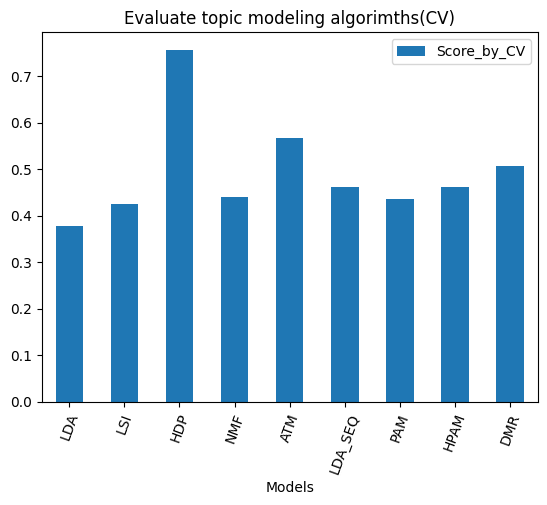

In [ ]:

# A python dictionary

data = {"Models":['LDA', 'LSI','HDP','NMF','ATM','LDA_SEQ','PAM','HPAM','DMR'],

        "Score_by_CV":[coherence_lda_cv, coherence_lsi_cv,hdp_coherence_cv,nmf_coherence_cv,coherence_ATM_CV,ldaseq_cv,PAM_cv_coherence,HPAM_cv_coherence,DMR_cv_coherence]

        };

# Dictionary loaded into a DataFrame

dataFrame = pd.DataFrame(data=data);



# Draw a vertical bar chart

dataFrame.plot.bar(x="Models", y="Score_by_CV", rot=70, title="Evaluate topic modeling algorimths(CV)");

plt.show(block=True);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


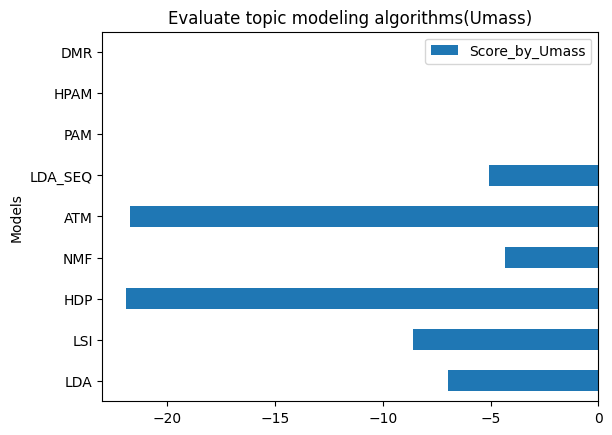

In [ ]:
# A python dictionary

data = {"Models":['LDA', 'LSI','HDP','NMF','ATM','LDA_SEQ','PAM','HPAM','DMR'],

        "Score_by_Umass":[coherence_lda_uMass, coherence_lsi_umass,hdp_coherence_umass,nmf_coherence_uMass,coherence_ATM_uMass,ldaseq_umass,PAM_umass_coherence,HPAM_umass_coherence,DMR_umass_coherence]

        };

# Dictionary loaded into a DataFrame

dataFrame = pd.DataFrame(data=data);



# Draw a vertical bar chart

dataFrame.plot.barh(x="Models", y="Score_by_Umass", title="Evaluate topic modeling algorithms(Umass)");

plt.show(block=True);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


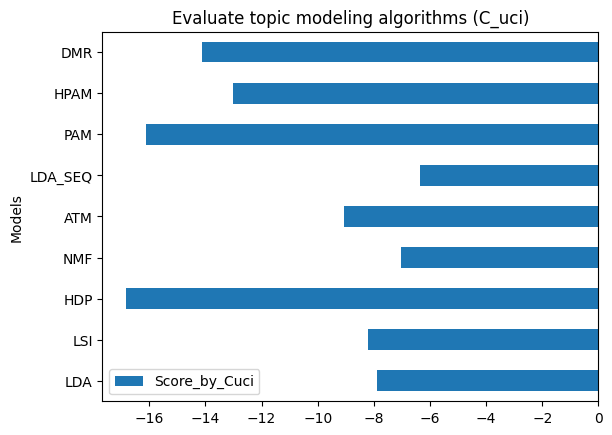

In [ ]:
# A python dictionary

data = {"Models":['LDA', 'LSI','HDP','NMF','ATM','LDA_SEQ','PAM','HPAM','DMR'],

        "Score_by_Cuci":[coherence_lda_uci, coherence_lsi_uci,hdp_coherence_uci,nmf_coherence_cuci,ATM_coherence_cuci,ldaseq_cuci,PAM_cuci_coherence,HPAM_cuci_coherence,DMR_cuci_coherence]

        };

# Dictionary loaded into a DataFrame

dataFrame = pd.DataFrame(data=data);



# Draw a vertical bar chart

dataFrame.plot.barh(x="Models", y="Score_by_Cuci", title="Evaluate topic modeling algorithms (C_uci)");

plt.show(block=True);